# Analyzer Notebook
## Introduction
This notebook contains code and graphs intended for exploratory analysis over the data and how the current `tix-time-processor` handles it. By no means should it be used as a testing method for the code, only to understand how the analysis are made and to improve further the results.

### Disclaimer 
We understand that having a Python Notebook inside a functioning service is wrong. This should be in another repository, with its own versioning and such. But such is life... This will be left like this for the moment until someone with more time can fix it. Kind regards.

### How to use this notebook
For the moment, the notebook should live in the root directory of the sourcecode repository such as it is now. Also, there should be a directory next to this by the name of `batch-test-reports`, which it should contain the data to analyze. It is **strongly** recommended that the data is split among directories containing the expected processing input for an specific moment in time. This is to better understand the processing.

## The Analysis
We will first setup everything in order to then run the code. Once the code was run, we will analyze with graphics how is it that we got to the show result
### The setup

In [51]:
# This will be a matplotlib notebook
%matplotlib notebook
# We import all the dependencies here
from functools import partial
from os import getcwd
from os.path import join

import pprint
import matplotlib.pyplot as plt
import numpy as np
from processor import analysis, reports
import pandas as pd

# And setup the basic stuff, configure the pretty printer, load the reports, setup the analyzer and
# define some more stuff.
pprinter = pprint.PrettyPrinter(indent=2)
rs = reports.ReportHandler.fetch_reports(join(getcwd(), 'batch-test-reports', '1505082284'))
ip, obs_set = reports.ReportHandler.collect_observations(rs)
analyzer = analysis.Analyzer(obs_set)

def get_bins_and_bins_probabilities_dfs(histogram, probabilities_name='probabilities'):
    bins_df = pd.DataFrame([{'min_value': bin_.min_value,
                             'mid_value': bin_.mid_value,
                             'max_value': bin_.max_value,
                             'width': bin_.width,
                             'data_points_qty': len(bin_.data)}
                            for bin_ in histogram.bins])
    bins_probabilities_normalized_df = pd.DataFrame(histogram.bins_probabilities, 
                                                        columns=[probabilities_name]) * (10 ** 8)
    bins_probabilities_df = pd.concat([bins_probabilities_normalized_df, 
                                       bins_df['mid_value']],
                                      axis=1)
    return bins_df, bins_probabilities_df


In [41]:
# Finally we print the results... This is what is expected to go to the API
pprinter.pprint(analyzer.get_results())

{ 'downstream': { 'hurst': { 'rs': 0.54183974717122507,
                             'wavelet': 0.46476179053909256},
                  'quality': 1.0,
                  'usage': 0.7071428571428572},
  'timestamp': 1505083171,
  'upstream': { 'hurst': { 'rs': 0.54663751515990722,
                           'wavelet': 0.43979928095871135},
                'quality': 1.0,
                'usage': 0.18571428571428572}}


### The RTT Histogram and the clock correction

<IPython.core.display.Javascript object>


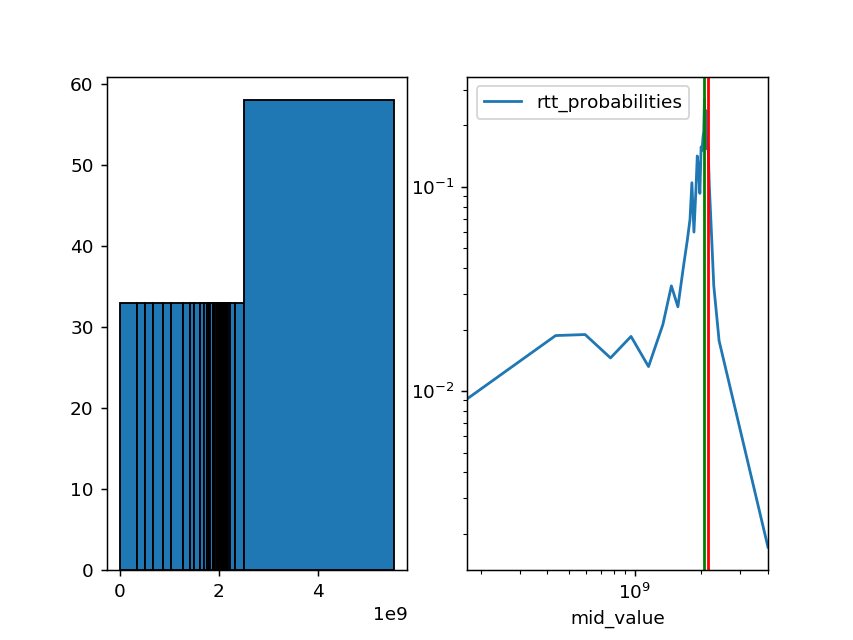

In [63]:
fig, axs = plt.subplots(1, 2)
rtt_bins_df, rtt_bins_probabilities_df = get_bins_and_bins_probabilities_dfs(analyzer.rtt_histogram, 
                                                                                        'rtt_probabilities')
data = [analyzer.rtt_histogram.characterization_function(d) for d in analyzer.rtt_histogram.data]
ranges = [b.min_value for b in analyzer.rtt_histogram.bins]
ranges.append(analyzer.rtt_histogram.bins[-1].max_value)
axs[0].hist(data, bins=ranges, edgecolor='black')
# rtt_bins_df.plot.bar('mid_value', 'width', logy=True, ax=axs[0])
rtt_bins_probabilities_df.plot('mid_value', 'rtt_probabilities', logy=True, logx=True, ax=axs[1])
axs[1].axvline(analyzer.rtt_histogram.mode, color='green')
axs[1].axvline(analyzer.rtt_histogram.threshold, color='red')

In [43]:
{'tau': analyzer.rtt_histogram.mode, 'tau_threshold': analyzer.rtt_histogram.threshold}

{'tau': 2067245286, 'tau_threshold': 2154202409.0}

### Clock Fixer

In [44]:
phis_timestamps
, phis = tuple(zip(*analyzer.clock_fixer.phis_for_minute))
fig, ax = plt.subplots()
regression_values = [analyzer.clock_fixer.slope * ts + analyzer.clock_fixer.intercept for ts in phis_timestamps]
ax.scatter(phis_timestamps, phis, s=1)
ax.plot(phis_timestamps, regression_values, '--', color='red')

TypeError: 'tuple' object is not callable

In [45]:
{'slope': analyzer.clock_fixer.slope, 'intercept': analyzer.clock_fixer.intercept}

{'intercept': 121617646345116.17, 'slope': -80805.247960415218}

In [46]:
{'r_value': analyzer.clock_fixer.r_value, 'p_value': analyzer.clock_fixer.p_value, 'std_err': analyzer.clock_fixer.std_err}

{'p_value': 2.5320319392214303e-17,
 'r_value': -0.25670346242466824,
 'std_err': 9379.883223672372}

### Data Usage

#### Upstream

<IPython.core.display.Javascript object>


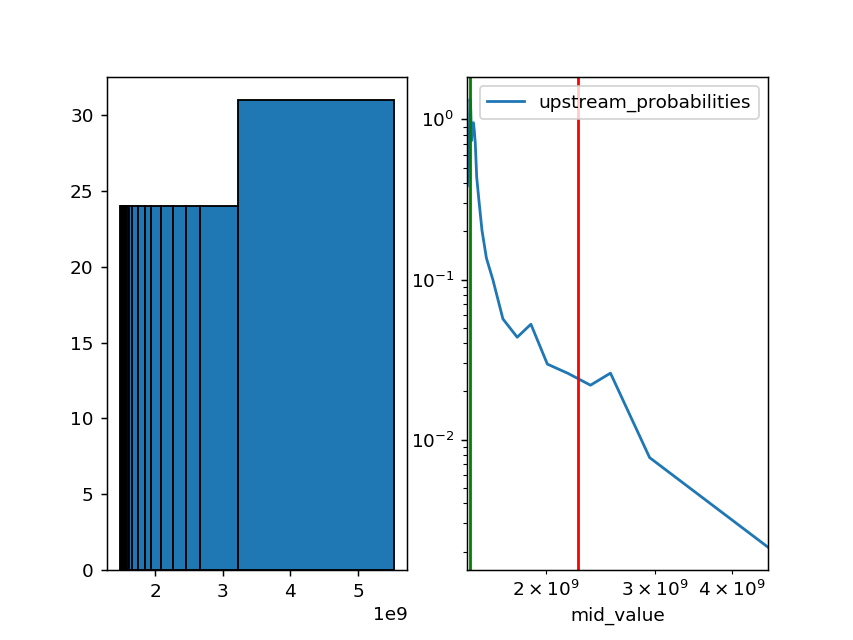

In [64]:
fig, axs = plt.subplots(1, 2)
upstream_bins_df, upstream_bins_probabilities_df = get_bins_and_bins_probabilities_dfs(analyzer.usage_calculator.upstream_histogram,
                                                                                                  'upstream_probabilities')
data = [analyzer.usage_calculator.upstream_histogram.characterization_function(d) 
        for d in analyzer.usage_calculator.upstream_histogram.data]
ranges = [b.min_value for b in analyzer.usage_calculator.upstream_histogram.bins]
ranges.append(analyzer.rtt_histogram.bins[-1].max_value)
axs[0].hist(data, bins=ranges, edgecolor='black')
# upstream_bins_df.plot.bar('mid_value', 'width', logy=True, ax=axs[0])
upstream_bins_probabilities_df.plot('mid_value', 'upstream_probabilities', logy=True, logx=True, ax=axs[1])
axs[1].axvline(analyzer.usage_calculator.upstream_histogram.mode, color='green')
axs[1].axvline(analyzer.usage_calculator.upstream_histogram.threshold, color='red')

In [48]:
{'upstream mode': analyzer.usage_calculator.upstream_histogram.mode,
 'upstream threshold': analyzer.usage_calculator.upstream_histogram.threshold}

{'upstream mode': 1506360786.140625, 'upstream threshold': 2252239309.5859375}

#### Dowstream

<IPython.core.display.Javascript object>


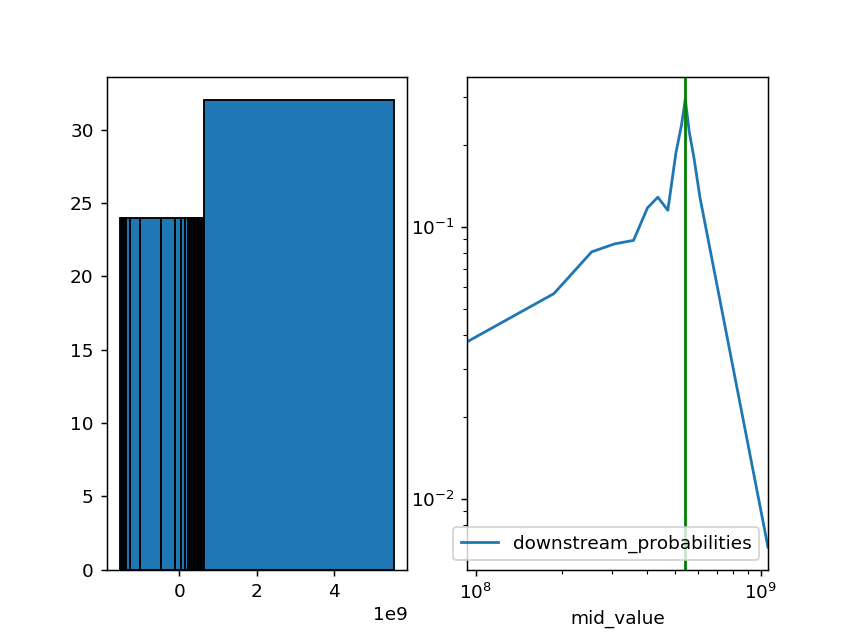

In [66]:
fig, axs = plt.subplots(1, 2)
downstream_bins_df, downstream_bins_probabilities_df = get_bins_and_bins_probabilities_dfs(analyzer.usage_calculator.downstream_histogram,
                                                                                                      'downstream_probabilities')
data = [analyzer.usage_calculator.downstream_histogram.characterization_function(d) 
        for d in analyzer.usage_calculator.downstream_histogram.data]
ranges = [b.min_value for b in analyzer.usage_calculator.downstream_histogram.bins]
ranges.append(analyzer.rtt_histogram.bins[-1].max_value)
axs[0].hist(data, bins=ranges, edgecolor='black')
# downstream_bins_df.plot.bar('mid_value', 'width', logy=True, ax=axs[0])
downstream_bins_probabilities_df.plot('mid_value', 'downstream_probabilities', logy=True, logx=True, ax=axs[1])
axs[1].axvline(analyzer.usage_calculator.downstream_histogram.mode, color='green')
axs[1].axvline(analyzer.usage_calculator.downstream_histogram.threshold, color='red')

In [50]:
{'downstream mode': analyzer.usage_calculator.downstream_histogram.mode,
 'downstream threshold': analyzer.usage_calculator.downstream_histogram.threshold}

{'downstream mode': 543477754.1875, 'downstream threshold': -207682660.8046875}

### Quality and Hurst values
#### Quality